# Scanflow inference with Kubernetes

## (Demo: Resnet50_v1 for ImageNet2012)

  1. serve the model
  
  2. interceptor preprocess and forward invocations
  
  3. track information by scanflow
  

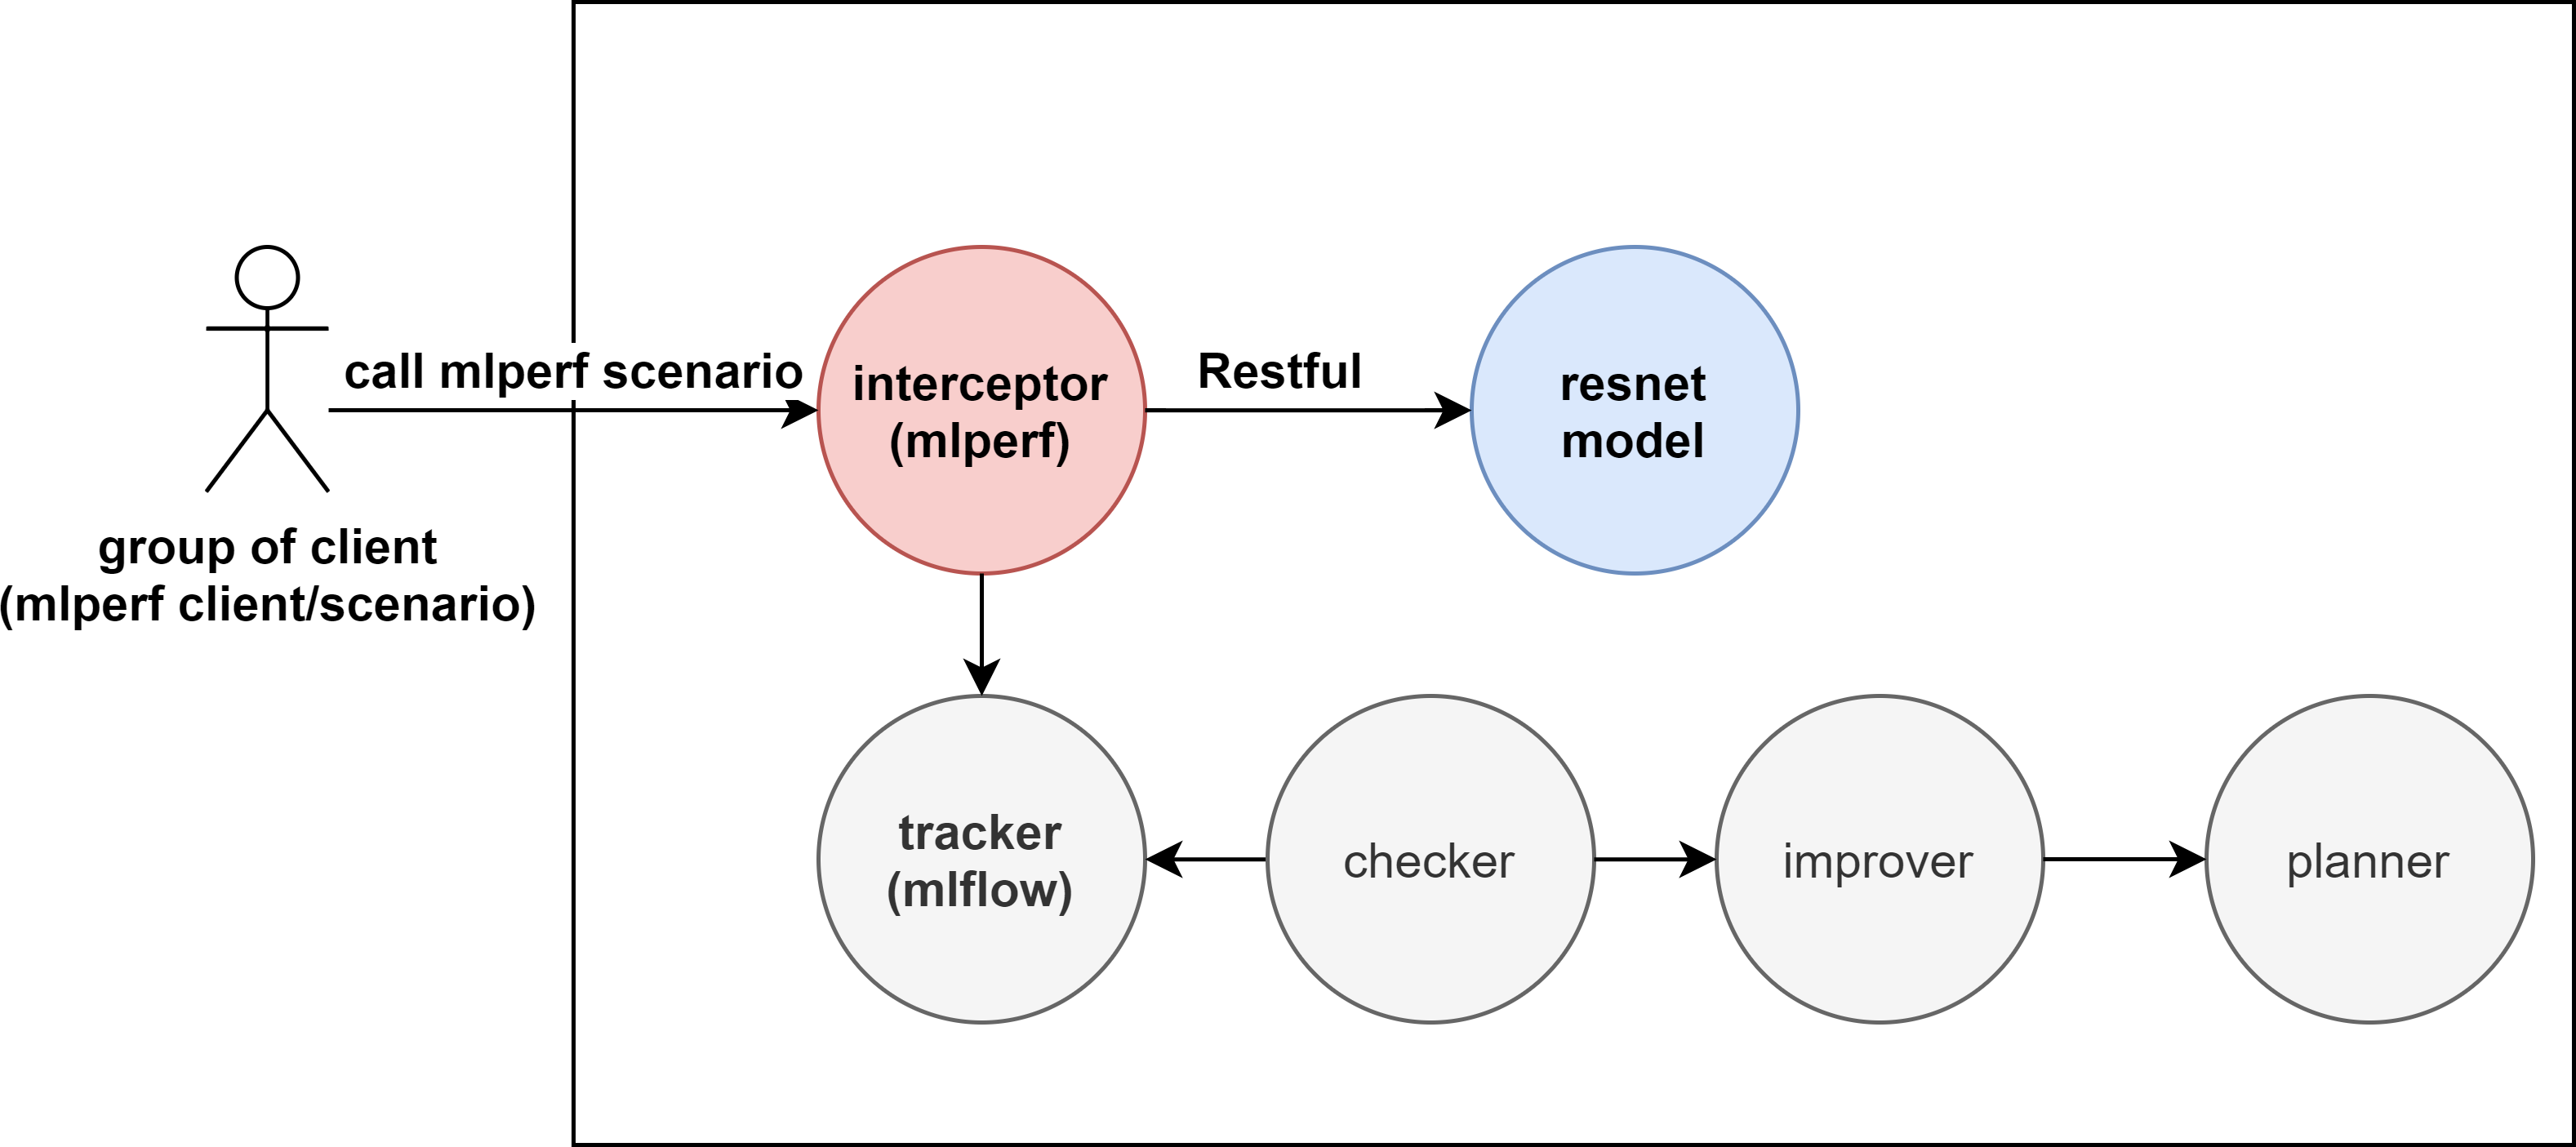

In [1]:
from IPython.display import Image
Image("/gpfs/bsc_home/xpliu/inference/images/inference.png", width=800, height=400)

## 1. Serve the model by using tfserving

In [ ]:
# download resnet model
mkdir /tmp/resnet
curl -s http://download.tensorflow.org/models/official/20181001_resnet/savedmodels/resnet_v2_fp32_savedmodel_NHWC_jpg.tar.gz | \
tar --strip-components=2 -C /tmp/resnet -xvz

#copy the model into tensorflow/serving
docker run -d --name serving_base tensorflow/serving
docker cp /tmp/resnet serving_base:/models/resnet
docker commit --change "ENV MODEL_NAME resnet" serving_base \
  172.30.0.49:5000/tensorflow-serving/resnet
    
#deploy on k8s - restnet service with 3 backend
apiVersion: apps/v1
kind: Deployment
metadata:
  name: resnet-deployment
spec:
  selector:
    matchLabels:
      app: resnet-server
  replicas: 3
  template:
    metadata:
      labels:
        app: resnet-server
    spec:
      containers:
      - name: resnet-container
        image: 172.30.0.49:5000/tensorflow-serving/resnet
        ports:
        - containerPort: 8500
---
apiVersion: v1
kind: Service
metadata:
  labels:
    run: resnet-service
  name: resnet-service
spec:
  ports:
  - port: 8500
    targetPort: 8501
    nodePort: 31930
  selector:
    app: resnet-server
  type: NodePort

## 2. mlperf as group of client + interceptor

usage: run_local.sh tf|onnxruntime|pytorch|tflite|tfserving [resnet50|mobilenet|ssd-mobilenet|ssd-resnet34] [cpu|gpu]

code: https://github.com/peiniliu/inference/tree/dev

In [ ]:
#build interceptor mount mlperf&data
docker build -f Dockerfile.modified.cpu -t 172.30.0.49:5000/interceptor .

    
#deploy on k8s - pod
apiVersion: v1
kind: PersistentVolume
metadata:
  name: data-path
  labels:
    type: local
spec:
  storageClassName: local-path
  capacity:
    storage: 10Gi
  accessModes:
    - ReadWriteMany
  hostPath:
    path: "/gpfs/bsc_home/xpliu/inference"
---
apiVersion: v1
kind: PersistentVolumeClaim
metadata:
  name: data-path
spec:
  storageClassName: local-path
  accessModes:
    - ReadWriteMany
  resources:
    requests:
      storage: 10Gi
---
apiVersion: v1
kind: Pod
metadata:
  name: interceptor-pod
  labels:
    app: interceptor-pod
spec:
  volumes:
  - name: data-path
    persistentVolumeClaim:
      claimName: data-path
  - name: tracker
    persistentVolumeClaim:
      claimName: resnettracker
  containers:
  - name: interceptor-pod
    image: 172.30.0.49:5000/interceptor
    imagePullPolicy: Always
    command: [ "/bin/bash", "-c", "--" ]
    args: [ "while true; do sleep 30; done;" ]
    env:
      - name: MLFLOW_TRACKING_URI
        value: http://tracker-service:8080
    volumeMounts:
      - name: data-path
        mountPath: /root
      - name: tracker
        mountPath: /mlflow

## 3. track information from interceptor

In [ ]:
# start scanflow-online tracker
http://172.30.0.50:30010/#/
# log metrics, artifacts

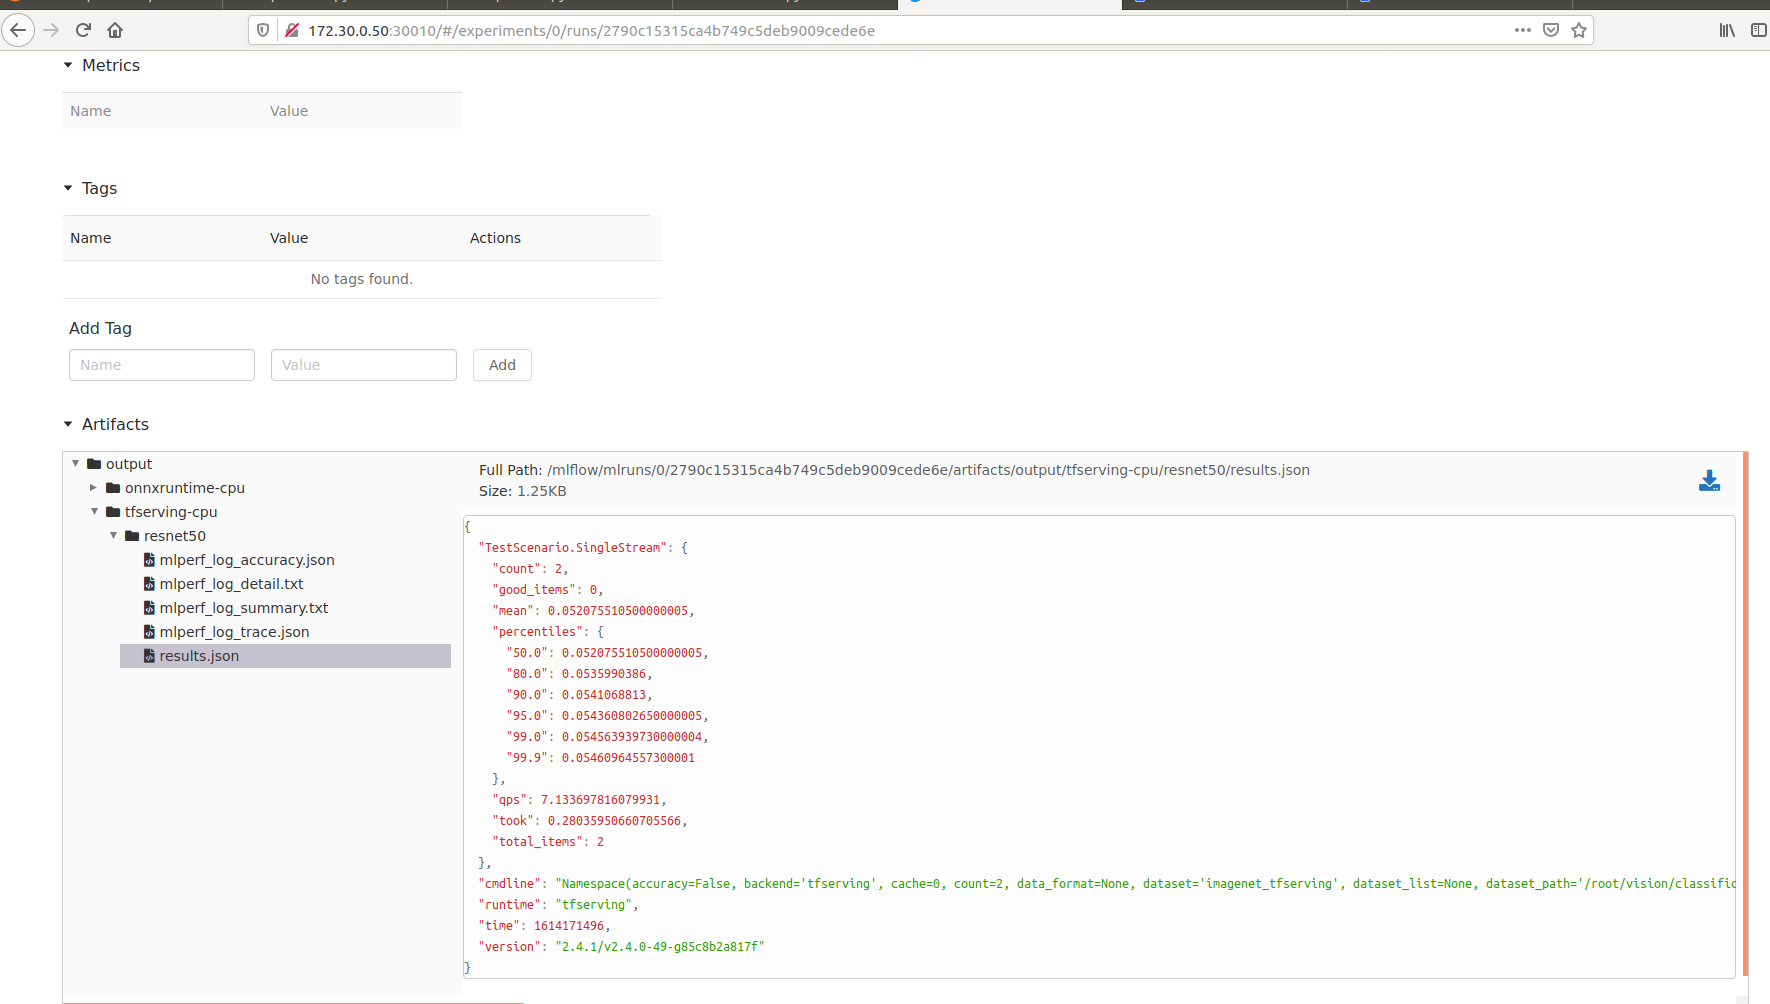

In [2]:
from IPython.display import Image
Image("/gpfs/bsc_home/xpliu/inference/images/mlflow-artifacts.PNG", width=800, height=400)